In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

#### Importing data

In [2]:
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

In [3]:

#returns with dididend payments yearly and monthly
Y_ret = pd.read_excel(filepath + 'DS_RI_USD_Y.xlsx')
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')

#market value yearly and monthly
Y_mval = pd.read_excel(filepath + 'DS_MV_USD_Y.xlsx')
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')

#revenue yearly
revenue = pd.read_excel(filepath + 'DS_REV_USD_Y.xlsx')

#risk free rate
rfr = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')

#Escores
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')

#Companies and Regions
companies = pd.read_excel(filepath + 'Static.xlsx')


#### Only consider Pacific companies

In [4]:
# Merge data with companies on ISIN and keep only records where Region = PAC
#   [companies['Region'].isin(['PAC'])] is used to filter the rows where Region = PAC

Y_ret = Y_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_ret = M_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_mval = Y_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_mval = M_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
revenue = revenue.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
escore = escore.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')

# Drop the duplicated columns from the merge
for df in [M_ret, Y_ret, M_mval, Y_mval, revenue, escore]:
    df.drop(columns=['Region'], inplace=True)


#### Melting dataframes to have them in long format

In [5]:
M_ret_w = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
Y_ret_w = Y_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
M_mval_w = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
Y_mval_w = Y_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
revenue_w = revenue.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="REVENUE")
escore_w = escore.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="ESCORE")

#### Making sure the data is correct

In [6]:
for df in [M_ret_w, M_mval_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)
    #date format d.m.y
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

for df in [Y_ret_w, Y_mval_w, revenue_w, escore_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)

#### Compute Annualized returns 

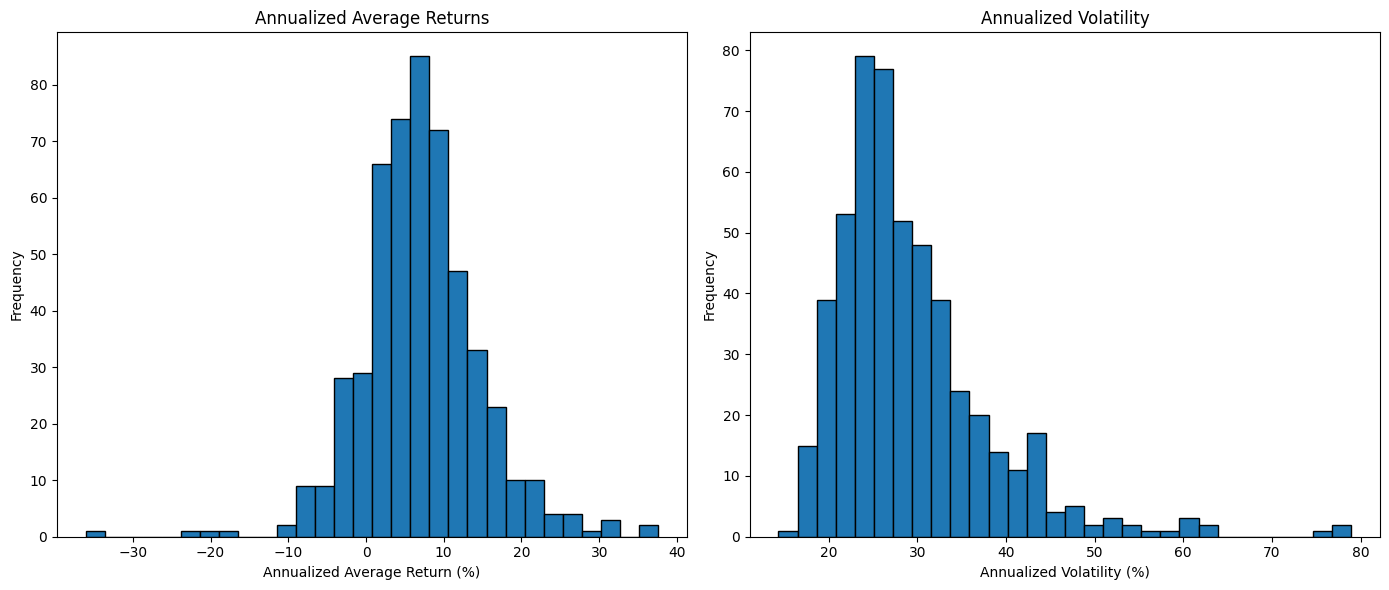

Correlation between annualized average returns and volatilities: 0.069


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data from 2014 to 2024
dfe1 = M_ret_w[(M_ret_w['DATE'] >= '2013-12-31') & (M_ret_w['DATE'] <= '2024-12-31')]

# Compute monthly returns in percentage
dfe1['RET_PCT'] = dfe1.groupby('ISIN')['RETURN'].pct_change() * 100

# Drop the first row (January 2014) of each ISIN
dfe1 = dfe1.dropna(subset=['RET_PCT'])

# Compute annualized average return and annualized volatility
annualized_returns = dfe1.groupby('ISIN')['RET_PCT'].mean() * 12
annualized_volatility = dfe1.groupby('ISIN')['RET_PCT'].std() * np.sqrt(12)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(annualized_returns, bins=30, edgecolor='k')
plt.title('Annualized Average Returns')
plt.xlabel('Annualized Average Return (%)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(annualized_volatility, bins=30, edgecolor='k')
plt.title('Annualized Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compute correlation between individual average returns and volatilities
correlation = annualized_returns.corr(annualized_volatility)
print(f'Correlation between annualized average returns and volatilities: {correlation:.3f}')

# Comment on the results
# - Analyze the shape and spread of the histograms.
# - Discuss any notable features or outliers.
# - Interpret the correlation coefficient and its implications.

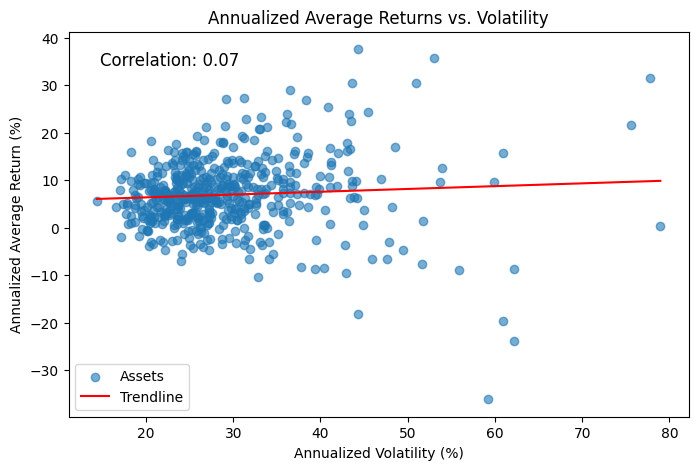

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(annualized_volatility, annualized_returns, alpha=0.6, label='Assets')
plt.title('Annualized Average Returns vs. Volatility')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Average Return (%)')

# Compute trendline
slope, intercept = np.polyfit(annualized_volatility, annualized_returns, 1)
x = np.linspace(annualized_volatility.min(), annualized_volatility.max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', label='Trendline')

# Display correlation
plt.text(
    0.05, 0.95,
    f'Correlation: {correlation:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

plt.legend()
plt.show()

Equally-Weighted Portfolio:
Annualized Return      : 6.14%
Annualized Volatility  : 14.30%
Sharpe Ratio           : 0.32
Minimum Monthly Return : -13.49%
Maximum Monthly Return : 13.09%

Value-Weighted Portfolio:
Annualized Return      : 10.96%
Annualized Volatility  : 13.48%
Sharpe Ratio           : 0.70
Minimum Monthly Return : -9.58%
Maximum Monthly Return : 13.95%


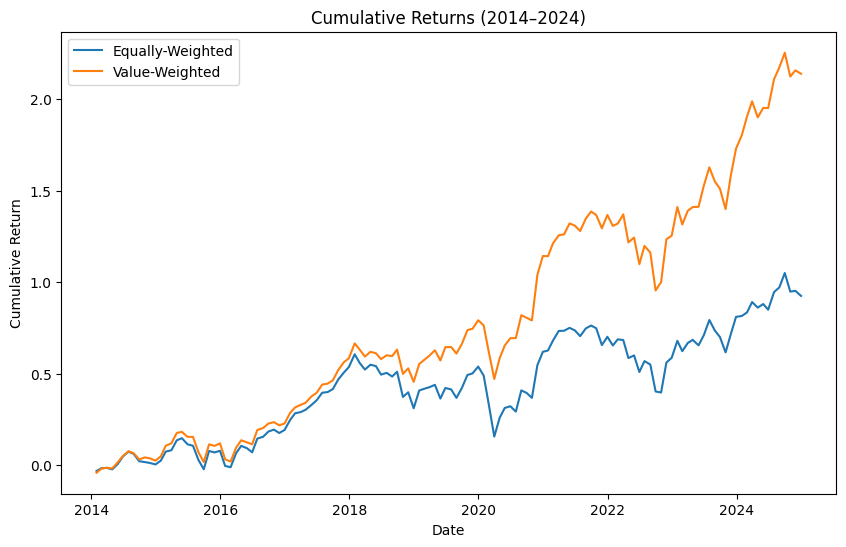

In [9]:
# The necessary data (dfe1, M_mval_w, rfr), functions, and imports have already been defined in previous cells.

# 1. Equally-Weighted Portfolio:
#    Each month, take a simple average of the percentage returns (RET_PCT).
ew_portfolio = dfe1.groupby('DATE')['RET_PCT'].mean().reset_index()
ew_portfolio['r'] = ew_portfolio['RET_PCT'] / 100.0

# 2. Value-Weighted Portfolio:
#    Use market values (MKT_VAL) from the monthly data to weight each firm’s return.
#    Merge them if not already merged, then compute weighted average.
data_vw = dfe1.drop(columns=['MKT_VAL'], errors='ignore')
vw_data = pd.merge(data_vw, M_mval_w, on=["NAME", "ISIN", "DATE"], how="inner")
vw_data["MKT_VAL"] = pd.to_numeric(vw_data["MKT_VAL"], errors="coerce")
vw_data = vw_data.dropna(subset=["MKT_VAL", "RET_PCT"])

def weighted_return(grp):
    total_cap = grp["MKT_VAL"].sum()
    return (grp["RET_PCT"] * grp["MKT_VAL"] / total_cap).sum()

vw_portfolio = vw_data.groupby("DATE").apply(weighted_return).reset_index(name="vw_RET_PCT")
vw_portfolio["r"] = vw_portfolio["vw_RET_PCT"] / 100.0

# 3. Combine and compute cumulative returns
port_returns = pd.merge(
    ew_portfolio[["DATE", "r"]],
    vw_portfolio[["DATE", "r"]],
    on="DATE",
    how="inner",
    suffixes=("_ew", "_vw")
).sort_values("DATE")

port_returns["cum_ew"] = (1 + port_returns["r_ew"]).cumprod() - 1
port_returns["cum_vw"] = (1 + port_returns["r_vw"]).cumprod() - 1

# 4. Function to compute portfolio statistics
def portfolio_stats(r_series):
    n = len(r_series)
    cumulative = (1 + r_series).prod()
    ann_return = cumulative ** (12 / n) - 1
    ann_vol = r_series.std() * np.sqrt(12)
    # Approximate risk-free rate over this period
    rf_temp = rfr.copy()
    rf_temp["year"] = rf_temp["Unnamed: 0"].astype(str).str[:4]
    rf_temp["month"] = rf_temp["Unnamed: 0"].astype(str).str[4:6]
    rf_temp["DATE"] = pd.to_datetime(rf_temp["year"] + "-" + rf_temp["month"] + "-01") + pd.offsets.MonthEnd(0)
    rf_temp = rf_temp[(rf_temp["DATE"] >= port_returns["DATE"].min()) &
                      (rf_temp["DATE"] <= port_returns["DATE"].max())]
    ann_rf = (rf_temp["RF"].mean() / 100) * 12
    sharpe = (ann_return - ann_rf) / ann_vol if ann_vol != 0 else np.nan
    return ann_return, ann_vol, sharpe, r_series.min(), r_series.max()

ew_ret_stats = portfolio_stats(port_returns["r_ew"])
vw_ret_stats = portfolio_stats(port_returns["r_vw"])

# 5. Print statistics
print("Equally-Weighted Portfolio:")
print(f"Annualized Return      : {ew_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {ew_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {ew_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {ew_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {ew_ret_stats[4]:.2%}\n")

print("Value-Weighted Portfolio:")
print(f"Annualized Return      : {vw_ret_stats[0]:.2%}")
print(f"Annualized Volatility  : {vw_ret_stats[1]:.2%}")
print(f"Sharpe Ratio           : {vw_ret_stats[2]:.2f}")
print(f"Minimum Monthly Return : {vw_ret_stats[3]:.2%}")
print(f"Maximum Monthly Return : {vw_ret_stats[4]:.2%}")

# 6. Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(port_returns["DATE"], port_returns["cum_ew"], label="Equally-Weighted")
plt.plot(port_returns["DATE"], port_returns["cum_vw"], label="Value-Weighted")
plt.title("Cumulative Returns (2014–2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

Ex-ante optimal portfolio (highest Sharpe ratio):
Return: 22.09%
Volatility: 13.46%
Sharpe Ratio: 1.49

Ex-post optimal portfolio (highest Sharpe ratio):
Target Return: 16.91%
Ex-post Return: 19.63%
Ex-post Volatility: 12.61%
Ex-post Sharpe Ratio: 1.42


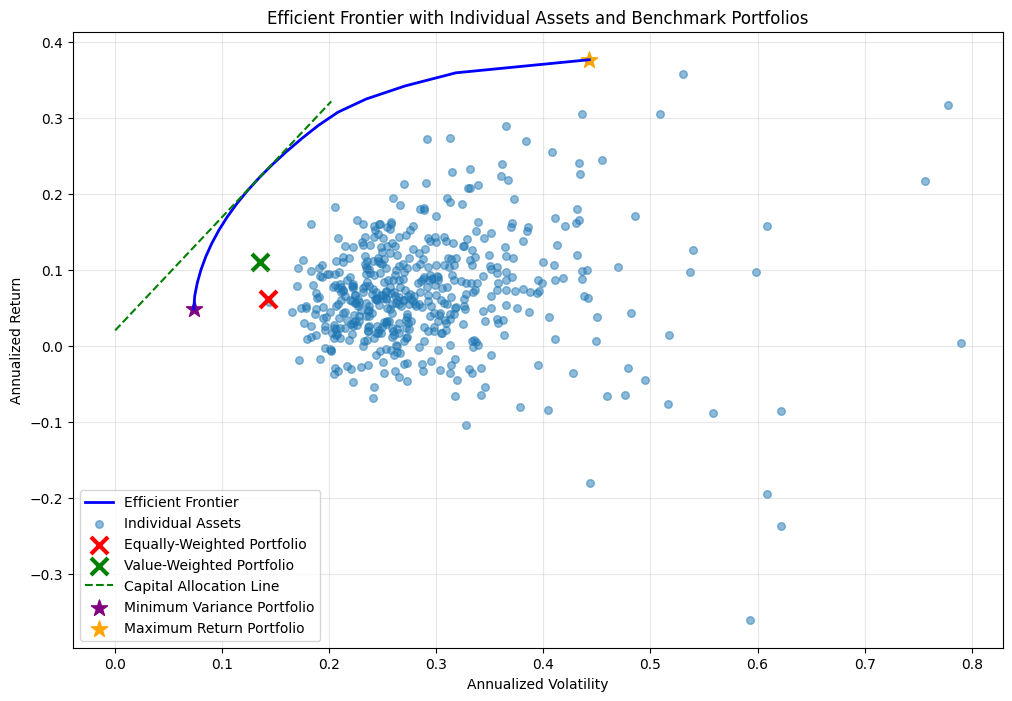

In [16]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. Filter firms with E/S/G scores or carbon emissions from 2013 on
escore_firms = escore[(~pd.isna(escore[2013])) | 
                      (~pd.isna(escore[2014])) |
                      (~pd.isna(escore[2015])) |
                      (~pd.isna(escore[2016])) |
                      (~pd.isna(escore[2017])) |
                      (~pd.isna(escore[2018])) |
                      (~pd.isna(escore[2019])) |
                      (~pd.isna(escore[2020])) |
                      (~pd.isna(escore[2021])) |
                      (~pd.isna(escore[2022])) |
                      (~pd.isna(escore[2023]))]['ISIN'].unique()

# 2. Filter returns data for these firms for 2014-2024 period
returns_2014_2024 = dfe1[dfe1['ISIN'].isin(escore_firms)].copy()

# 3. Expected (monthly) returns and covariance matrix (annualized later)
T = returns_2014_2024['DATE'].nunique()  # number of months
expected_returns = returns_2014_2024.groupby('ISIN')['RET_PCT'].mean() / 100.0  # monthly average
pivot_returns = returns_2014_2024.pivot_table(index='DATE', columns='ISIN', values='RET_PCT') / 100.0
cov_matrix = pivot_returns.cov()   # sample covariance (monthly)
# Optionally, annualize later when returning portfolio metrics

# 4. Portfolio functions
def portfolio_return(weights, returns):
    return np.sum(weights * returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Negative Sharpe for ex-ante optimization (annualized return and volatility)
def negative_sharpe(weights, returns, cov_matrix, risk_free_rate=0.02/12):
    p_ret = portfolio_return(weights, returns)*12
    p_vol = portfolio_volatility(weights, cov_matrix)*np.sqrt(12)
    return -(p_ret - risk_free_rate*12) / p_vol

# 5. Minimum variance portfolio optimization
def min_variance_portfolio(returns, cov_matrix):
    num_assets = len(returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(lambda x: portfolio_volatility(x, cov_matrix), 
                      np.ones(num_assets) / num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    weights = result['x']
    return {
        'weights': weights,
        'return': portfolio_return(weights, returns)*12,  # annualized
        'volatility': portfolio_volatility(weights, cov_matrix)*np.sqrt(12)
    }

# 6. Maximum return portfolio optimization
def max_return_portfolio(returns, cov_matrix):
    num_assets = len(returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(lambda x: -portfolio_return(x, returns), 
                      np.ones(num_assets) / num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    weights = result['x']
    return {
        'weights': weights,
        'return': portfolio_return(weights, returns)*12,  # annualized
        'volatility': portfolio_volatility(weights, cov_matrix)*np.sqrt(12)
    }

# 7. Efficient frontier: minimize volatility subject to portfolio return >= target
def efficient_return(returns, cov_matrix, target):
    num_assets = len(returns)
    constraints = [
        {'type': 'ineq', 'fun': lambda x: portfolio_return(x, returns)*12 - target},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    ]
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(lambda x: portfolio_volatility(x, cov_matrix),
                      np.ones(num_assets) / num_assets,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    if not result['success']:
        print("Optimization did not converge:", result['message'])
    return result['x']

# 8. Compute ex-ante optimal portfolios
min_var = min_variance_portfolio(expected_returns, cov_matrix)
max_ret = max_return_portfolio(expected_returns, cov_matrix)

# 9. Generate efficient frontier portfolios
# Use increments (here, approximately 0.5% steps in annualized return)
target_returns = np.linspace(min_var['return'], max_ret['return'], 20)
efficient_portfolios = []

for target in target_returns:
    weights = efficient_return(expected_returns, cov_matrix, target)
    eff_vol = portfolio_volatility(weights, cov_matrix)*np.sqrt(12)
    efficient_portfolios.append({
        'weights': weights,
        'return': target,
        'volatility': eff_vol
    })

# 10. Ex-post performance: use all monthly returns from pivot_returns
for portfolio in efficient_portfolios:
    weights = portfolio['weights']
    monthly_returns = pivot_returns.dot(weights)
    ann_return = monthly_returns.mean()*12
    ann_vol = monthly_returns.std()*np.sqrt(12)
    
    # Calculate average risk-free rate over the period from rfr dataframe
    rf_temp = rfr.copy()
    rf_temp["year"] = rf_temp["Unnamed: 0"].astype(str).str[:4]
    rf_temp["month"] = rf_temp["Unnamed: 0"].astype(str).str[4:6]
    rf_temp["DATE"] = pd.to_datetime(rf_temp["year"] + "-" + rf_temp["month"] + "-01")
    avg_rf = (rf_temp["RF"].mean() / 100)*12  # annualized rf
    
    sharpe = (ann_return - avg_rf) / ann_vol if ann_vol != 0 else 0
    portfolio['ex_post_return'] = ann_return
    portfolio['ex_post_volatility'] = ann_vol
    portfolio['ex_post_sharpe'] = sharpe

# Identify optimal portfolios by ex-ante and ex-post Sharpe
ex_ante_sharpe = [(p['return'] - (0.02)) / p['volatility'] for p in efficient_portfolios]  # using 2% annual rf
max_sharpe_idx = np.argmax(ex_ante_sharpe)
max_sharpe_port = efficient_portfolios[max_sharpe_idx]

ex_post_sharpe = [p['ex_post_sharpe'] for p in efficient_portfolios]
max_expost_idx = np.argmax(ex_post_sharpe)
max_expost_port = efficient_portfolios[max_expost_idx]

# 11. Plotting
plt.figure(figsize=(12, 8))

# Plot efficient frontier
ef_returns = [p['return'] for p in efficient_portfolios]
ef_volatility = [p['volatility'] for p in efficient_portfolios]
plt.plot(ef_volatility, ef_returns, 'b-', linewidth=2, label='Efficient Frontier')

# Plot individual assets
asset_volatility = [np.sqrt(cov_matrix.loc[asset, asset])*np.sqrt(12) for asset in expected_returns.index]
asset_returns = [expected_returns[asset]*12 for asset in expected_returns.index]
plt.scatter(asset_volatility, asset_returns, marker='o', s=30, alpha=0.5, label='Individual Assets')

# Plot equally-weighted and value-weighted portfolios
plt.scatter(ew_volatility, ew_return, marker='x', color='red', s=150, linewidths=3, label='Equally-Weighted Portfolio')
plt.scatter(vw_volatility, vw_return, marker='x', color='green', s=150, linewidths=3, label='Value-Weighted Portfolio')

# Capital allocation line (CAL)
slope = (max_sharpe_port['return'] - (0.02)) / max_sharpe_port['volatility']  # using 2% rf annualized
x_cal = np.linspace(0, max_sharpe_port['volatility']*1.5, 100)
y_cal = (0.02) + slope * x_cal
plt.plot(x_cal, y_cal, 'g--', label='Capital Allocation Line')

# Plot min variance and max return portfolios
plt.scatter(min_var['volatility'], min_var['return'], marker='*', color='purple', s=150, label='Minimum Variance Portfolio')
plt.scatter(max_ret['volatility'], max_ret['return'], marker='*', color='orange', s=150, label='Maximum Return Portfolio')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier with Individual Assets and Benchmark Portfolios')
plt.grid(alpha=0.3)
plt.legend()

# Print summary statistics
print("Ex-ante optimal portfolio (highest Sharpe ratio):")
print(f"Return: {max_sharpe_port['return']:.2%}")
print(f"Volatility: {max_sharpe_port['volatility']:.2%}")
print(f"Sharpe Ratio: {ex_ante_sharpe[max_sharpe_idx]:.2f}")

print("\nEx-post optimal portfolio (highest Sharpe ratio):")
print(f"Target Return: {max_expost_port['return']:.2%}")
print(f"Ex-post Return: {max_expost_port['ex_post_return']:.2%}")
print(f"Ex-post Volatility: {max_expost_port['ex_post_volatility']:.2%}")
print(f"Ex-post Sharpe Ratio: {max_expost_port['ex_post_sharpe']:.2f}")

plt.show()
